# 2021/12/30
# 本代码绘制论文version1.2中的fig7
# 内容为逐日的海温与2m风

In [1]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl

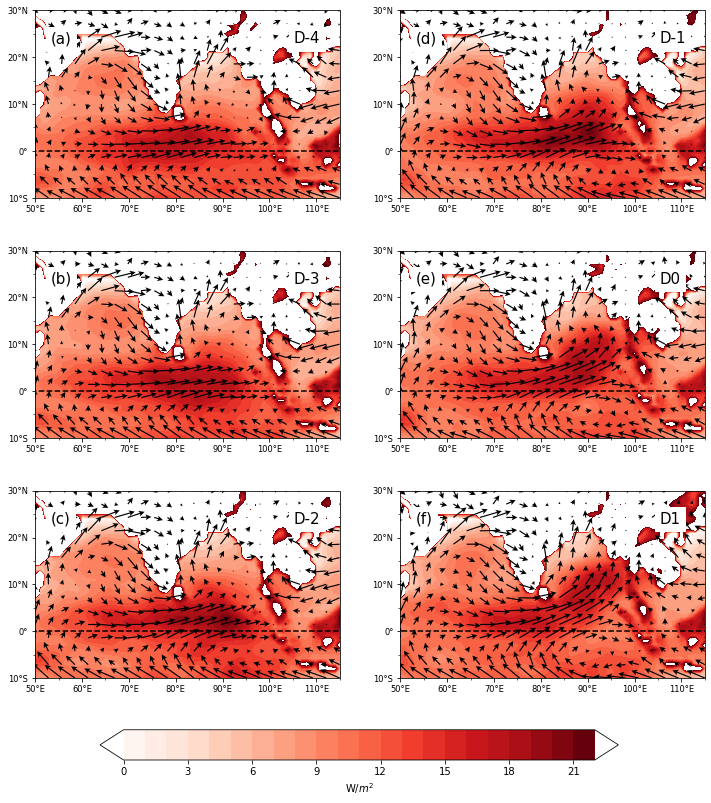

In [2]:
path  =  "/home/sun/qomo-data/"
lon_slice  =  slice(40,120)
lat_slice  =  slice(-15,40)

lonmin,lonmax,latmin,latmax  =  50,115,-10,30
extent     =  [lonmin,lonmax,latmin,latmax]

f1  =  xr.open_dataset(path+"composite-merra2-single.nc").sel(lon=lon_slice,lat=lat_slice)   
#f2  =  xr.open_dataset(path+"composite_OISST.nc").sel(lon=lon_slice,lat=lat_slice)  
f2  =  xr.open_dataset(path+"composite_shlh.nc").sel(lon=lon_slice,lat=slice(40,-15)) 

date  =  [-4,-3,-2,-1,0,1]
dates =  [26,27,28,29,30,31]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Reds', 22)
newcolors = viridis(np.linspace(0, 1, 22))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('white')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,14))
spec1   =  fig1.add_gridspec(nrows=3,ncols=2)

j = 0
    
for col in range(2):
    for row in range(3):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='small')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im  =  ax.contourf(f2.lon,f2.lat,-1*f2.SSHF[dates[j]]/86400,np.linspace(0,22,23),cmap=newcmp,alpha=1,extend='both')
            q  =  ax.quiver(f1.lon, f1.lat, f1.U2M.data[dates[j],:], f1.V2M.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='W/${m^2}$')

plt.savefig("/home/sun/paint/lunwen/version1.2/fig6_version1.2_2m_sh.pdf",dpi=300)

# 计算涡度

In [3]:
# 计算四月平均涡度
f1  =  xr.open_dataset(path+"composite-merra2-single.nc")
disy,disx,location = cal_xydistance(f1.lat,f1.lon)

vx  =  f1.U2M.data.copy() ; uy  =  vx.copy()

for i in range(1,180):
    vx[:,i,:]  =  np.gradient(f1.V2M.data[:,i,:],disx[i],axis=1)
    
uy  =  np.gradient(f1.U2M.data,location,axis=1)

april_mean_vor  =  np.average(vx[0:30,:],axis=0)  -  np.average(uy[0:30,:],axis=0)
vorticity       =  vx - uy

ncfile   =  xr.Dataset(
    {
        "april_vorticity": (["lat", "lon"], april_mean_vor),
        "vorticity": (["time","lat","lon"], vorticity),
    },
    coords={
        "lon": (["lon"], f1.lon.data),
        "lat": (["lat"], f1.lat.data),
        "time": (["time"], f1.time.data),
    },
)

In [4]:
path  =  "/home/sun/qomo-data/"
lon_slice  =  slice(40,120)
lat_slice  =  slice(-15,40)

lonmin,lonmax,latmin,latmax  =  50,115,-10,30
extent     =  [lonmin,lonmax,latmin,latmax]

f1  =  xr.open_dataset(path+"composite-merra2-single.nc").sel(time=slice(1,35))
f2  =  xr.open_dataset(path+"composite_shlh_liuxl.nc").sel(time=slice(1,35))
f3  =  ncfile.sel(lon=slice(70,100),lat=slice(-5,20)) 

# 屏蔽陆地感热
f_mask  =  xr.open_dataset("/home/sun/data/merra2_mask_1x1.nc")
mask    =  f_mask.mask_1x1.data
# 只保留海域的把陆地的给mask掉
sh      =  f2.SSHF.data
u2m     =  f1.U2M.data
v2m     =  f1.V2M.data

for tt in range(35):
    for i in range(181):
        for j in range(360):
            if mask[i,j] > 0.8:
                sh[tt,i,j]   =  np.nan
                vorticity[tt,i,j]  =  np.nan


# 打包
ncfile_nan   =  xr.Dataset(
    { 
        "sh": (["time","lat", "lon"], sh),
        "u2m": (["time","lat","lon"], u2m),
        "v2m": (["time","lat","lon"], v2m),
    },
    coords={
        "lon": (["lon"], f1.lon.data),
        "lat": (["lat"], f1.lat.data),
        "time": (["time"], f1.time.data),
    },
)

ncfile   =  xr.Dataset(
    {
        "april_vorticity": (["lat", "lon"], april_mean_vor),
        "vorticity": (["time","lat","lon"], vorticity),
    },
    coords={
        "lon": (["lon"], f1.lon.data),
        "lat": (["lat"], f1.lat.data),
        "time": (["time"], f1.time.data),
    },
)

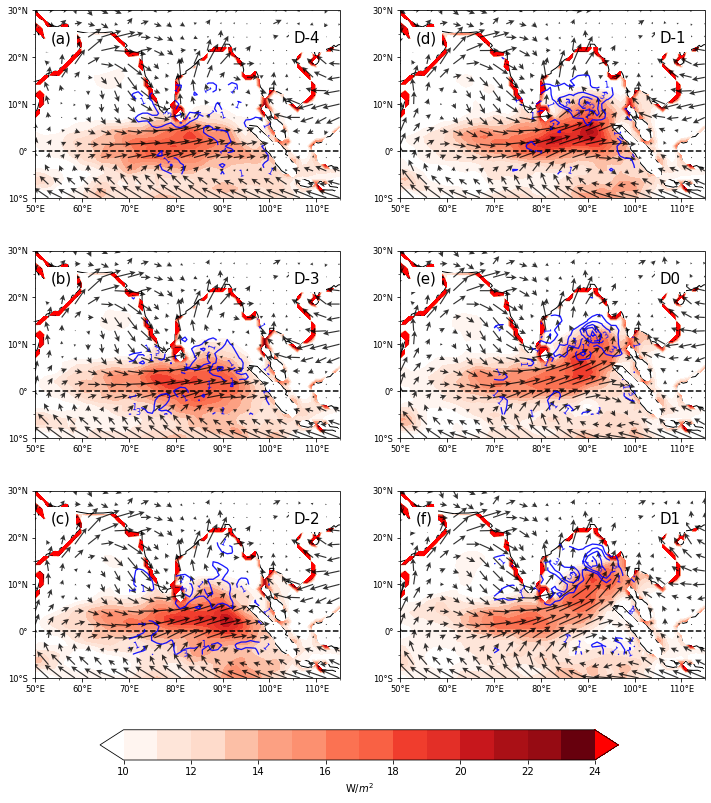

In [5]:
date  =  [-4,-3,-2,-1,0,1]
dates =  [26,27,28,29,30,31]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Reds', 22)
newcolors = viridis(np.linspace(0, 1, 22))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('red')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,14))
spec1   =  fig1.add_gridspec(nrows=3,ncols=2)

j = 0
    
for col in range(2):
    for row in range(3):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='small')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im1  =  ax.contourf(ncfile_nan.lon,ncfile_nan.lat,-1*ncfile_nan.sh[dates[j]]/86400,np.linspace(10,24,15),cmap=newcmp,alpha=1,extend='both')
            im2  =  ax.contour(f3.lon,f3.lat,1e6*(f3.vorticity.data[dates[j],:]-f3.vorticity.data[dates[j]-1,:]),np.linspace(1,11,6),colors='b',alpha=0.9,linewidths=1.3)
            ax.clabel(im2, np.linspace(1,11,6).astype(int), inline=True, fontsize=8)
            q  =  ax.quiver(f1.lon, f1.lat, ncfile_nan.u2m.data[dates[j],:], ncfile_nan.v2m.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5,alpha=0.8)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im1, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='W/${m^2}$')

plt.savefig("/home/sun/paint/lunwen/version1.3-20220108/fig6_version1.3_2m_sh_vorticity.pdf",dpi=300)

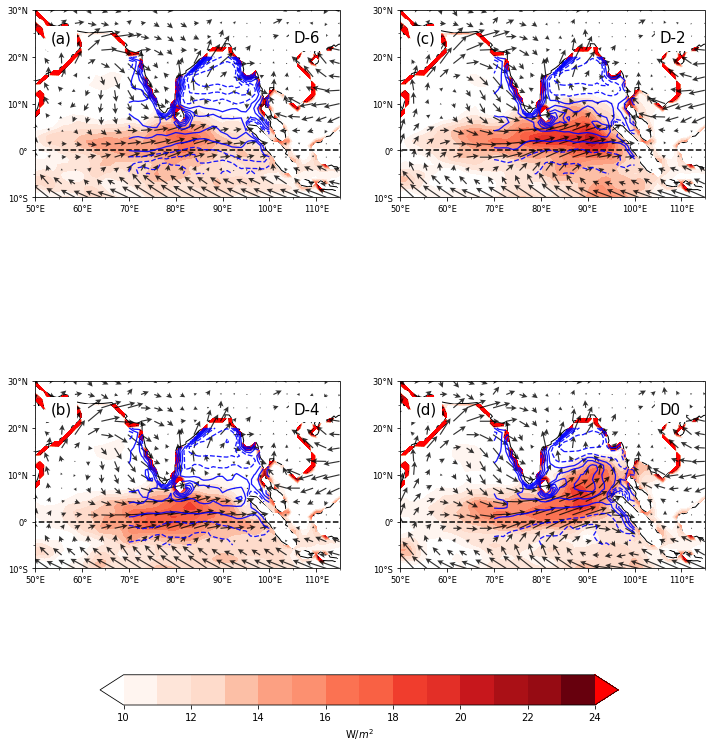

In [7]:
date  =  [-6,-4,-2,0]
dates =  [24,26,28,30]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np

viridis = cm.get_cmap('Reds', 22)
newcolors = viridis(np.linspace(0, 1, 22))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('red')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,14))
spec1   =  fig1.add_gridspec(nrows=2,ncols=2)

j = 0
    
for col in range(2):
    for row in range(2):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='small')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im1  =  ax.contourf(ncfile_nan.lon,ncfile_nan.lat,-1*ncfile_nan.sh[dates[j]]/86400,np.linspace(10,24,15),cmap=newcmp,alpha=1,extend='both')
            im2  =  ax.contour(f3.lon,f3.lat,1e6*(f3.vorticity.data[dates[j],:]),11,colors='b',alpha=0.9,linewidths=1.3)
            #ax.clabel(im2, np.linspace(1,11,6).astype(int), inline=True, fontsize=8)
            q  =  ax.quiver(f1.lon, f1.lat, ncfile_nan.u2m.data[dates[j],:], ncfile_nan.v2m.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5,alpha=0.8)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im1, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='W/${m^2}$')

plt.savefig("/home/sun/paint/lunwen/version2.0/fig6_version1.3_2m_sh_vorticity.pdf",dpi=300)

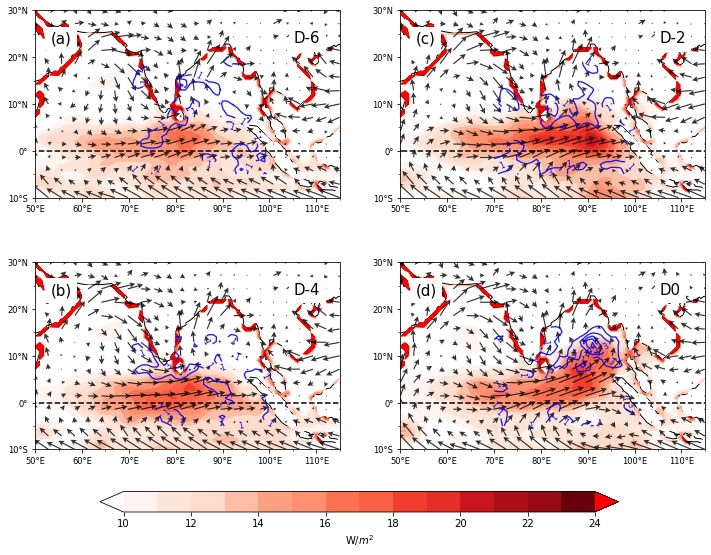

In [10]:
date  =  [-6,-4,-2,0]
dates =  [24,26,28,30]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Reds', 22)
newcolors = viridis(np.linspace(0, 1, 22))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('red')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,9.5))
spec1   =  fig1.add_gridspec(nrows=2,ncols=2)

j = 0
    
for col in range(2):
    for row in range(2):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='small')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im1  =  ax.contourf(ncfile_nan.lon,ncfile_nan.lat,-1*ncfile_nan.sh[dates[j]]/86400,np.linspace(10,24,15),cmap=newcmp,alpha=1,extend='both')
            im2  =  ax.contour(f3.lon,f3.lat,1e6*(f3.vorticity.data[dates[j],:]-f3.vorticity.data[dates[j]-1,:]),np.linspace(1,11,6),colors='b',alpha=0.9,linewidths=1.3)
            ax.clabel(im2, np.linspace(1,11,6).astype(int), inline=True, fontsize=8)
            q  =  ax.quiver(f1.lon, f1.lat, ncfile_nan.u2m.data[dates[j],:], ncfile_nan.v2m.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5,alpha=0.8)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im1, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='W/${m^2}$')

plt.savefig("/home/sun/paint/lunwen/version2.0/fig6_version1.3_2m_sh_vorticity.pdf",dpi=300)

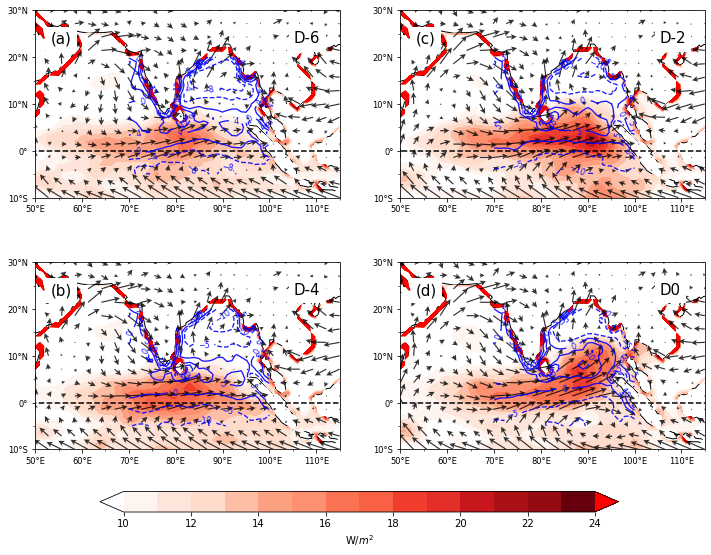

In [11]:
date  =  [-6,-4,-2,0]
dates =  [24,26,28,30]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Reds', 22)
newcolors = viridis(np.linspace(0, 1, 22))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
newcmp.set_over('red')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,9.5))
spec1   =  fig1.add_gridspec(nrows=2,ncols=2)

j = 0
    
for col in range(2):
    for row in range(2):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='small')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im1  =  ax.contourf(ncfile_nan.lon,ncfile_nan.lat,-1*ncfile_nan.sh[dates[j]]/86400,np.linspace(10,24,15),cmap=newcmp,alpha=1,extend='both')
            im2  =  ax.contour(f3.lon,f3.lat,1e6*(f3.vorticity.data[dates[j],:]),8,colors='b',alpha=0.9,linewidths=1.3)
            ax.clabel(im2, inline=True, fontsize=8)
            q  =  ax.quiver(f1.lon, f1.lat, ncfile_nan.u2m.data[dates[j],:], ncfile_nan.v2m.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=1,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5,alpha=0.8)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im1, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='W/${m^2}$')

plt.savefig("/home/sun/paint/lunwen/version2.0/fig6_version1.3_2m_sh_vorticity-2.pdf",dpi=300)